<a href="https://colab.research.google.com/github/nor23019/BRB-Construction/blob/main/notebooks/starter_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Note: After you run this cell, the training and test data will be available in
# the file browser. (Click the folder icon on the left to view it)
#
# If you don't see the data after the cell completes, click the refresh button
# in the file browser (folder icon with circular arrow)

# First, let's download and unzip the data
!echo "Downloading files..."
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training1.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/training2.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout.zip
!wget -q https://github.com/byui-cse/cse450-course/raw/master/data/roadsigns/mini_holdout_answers.csv

!echo "Unzipping files..."
!unzip -q /content/training1.zip
!unzip -q /content/training2.zip
!unzip -q /content/holdout.zip
!unzip -q /content/mini_holdout.zip

# Combine the two traning directories
!echo "Merging training data..."
!mkdir /content/training
!mv /content/training1/* /content/training
!mv /content/training2/* /content/training

# Cleanup
!echo "Cleaning up..."
!rmdir /content/training1
!rmdir /content/training2
!rm training1.zip
!rm training2.zip
!rm holdout.zip
!rm mini_holdout.zip

!echo "Data ready."

Unzipping files...
Merging training data...
Cleaning up...
Data ready.


In [ ]:
# Import libraries
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
# We're using keras' ImageDataGenerator class to load our image data.
# See (https://keras.io/api/preprocessing/image/#imagedatagenerator-class) for details
#
# A couple of things to note:
# 1. We're specifying a number for the seed, so we'll always get the same shuffle and split of our images.
# 2. Class names are inferred automatically from the image subdirectory names.
# 3. We're splitting the training data into 80% training, 20% validation.


training_dir = '/content/training/'
image_size = (100, 100)

# Split up the training data images into training and validations sets
# We'll use and ImageDataGenerator to do the splits
# ImageDataGenerator can also be used to do preprocessing and agumentation on the files as can be seen with rescale

train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
        )
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=.2
        )

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size = image_size,
        subset="training",
        batch_size=32,
        class_mode='sparse',
        seed=42,shuffle=True)
validation_generator = validation_datagen.flow_from_directory(
        training_dir,
        target_size=image_size,
        batch_size=32,
        class_mode='sparse',
        subset="validation",
        seed=42)



Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


In [ ]:
#these might come in handy
target_names = ['Speed_20', 'Speed_30', 'Speed_50', 'Speed_60', 'Speed_70',
               'Speed_80','Speed_Limit_Ends', 'Speed_100', 'Speed_120', 'Overtaking_Prohibited',
               'Overtakeing_Prohibited_Trucks', 'Priority', 'Priority_Road_Ahead', 'Yield', 'STOP',
               'Entry_Forbidden', 'Trucks_Forbidden', 'No_Entry(one-way traffic)', 'General Danger(!)', 'Left_Curve_Ahead',
               'Right_Curve_Ahead', 'Double_Curve', 'Poor_Surface_Ahead', 'Slippery_Surface_Ahead', 'Road_Narrows_On_Right',
               'Roadwork_Ahead', 'Traffic_Light_Ahead', 'Warning_Pedestrians', 'Warning_Children', 'Warning_Bikes',
               'Ice_Snow', 'Deer_Crossing', 'End_Previous_Limitation', 'Turning_Right_Compulsory', 'Turning_Left_Compulsory',
               'Ahead_Only', 'Straight_Or_Right_Mandatory', 'Straight_Or_Left_Mandatory', 'Passing_Right_Compulsory', 'Passing_Left_Compulsory',
               'Roundabout', 'End_Overtaking_Prohibition', 'End_Overtaking_Prohibition_Trucks']

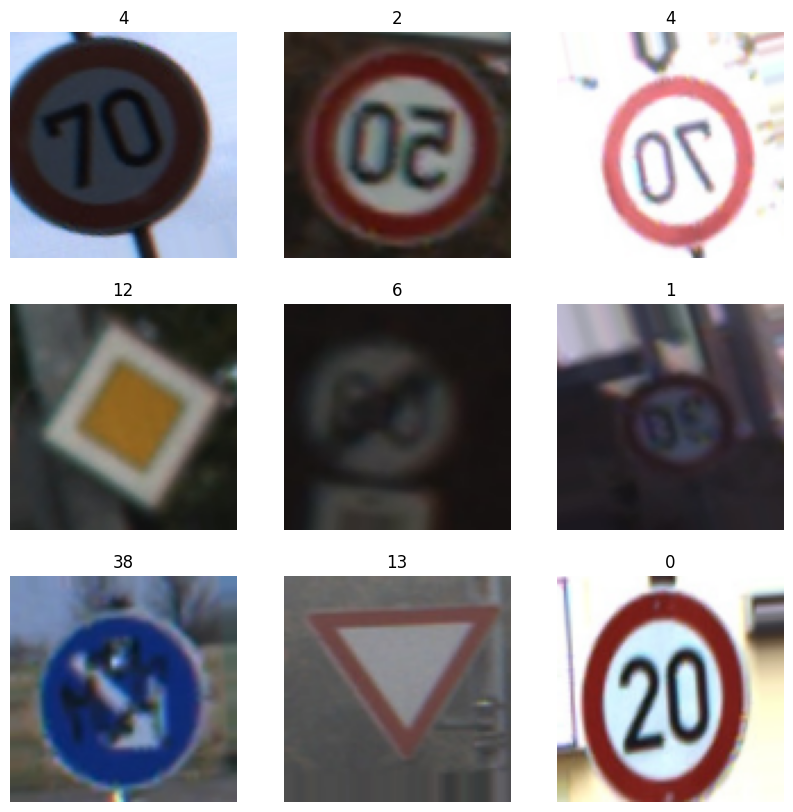

In [ ]:
# View 9 images and their class labels
plt.figure(figsize=(10, 10))
images, labels = next(train_generator)  # Assuming train_generator is a generator
batch_size = images.shape[0]

for i in range(min(9, batch_size)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i] * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

In [ ]:
# Build a model...
model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100,100,3)),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Conv2D(128, (3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),

    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(43, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

#Train it
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=12
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,381,355 (12.90 MB)

 Trainable params: 3,381,355 (12.90 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 108s 106ms/step - accuracy: 0.2502 - loss: 2.6625 - val_accuracy: 0.5246 - val_loss: 1.4798
Epoch 2/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 101s 103ms/step - accuracy: 0.5938 - loss: 1.2029 - val_accuracy: 0.6682 - val_loss: 1.0648
Epoch 3/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 101s 103ms/step - accuracy: 0.7342 - loss: 0.7803 - val_accuracy: 0.7363 - val_loss: 0.8425
Epoch 4/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 101s 103ms/step - accuracy: 0.8058 - loss: 0.5695 - val_accuracy: 0.7614 - val_loss: 0.8327
Epoch 5/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 102s 104ms/step - accuracy: 0.8400 - loss: 0.4576 - val_accuracy: 0.8024 - val_loss: 0.7211
Epoch 6/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 139s 101ms/step - accuracy: 0.8704 - loss: 0.3771 - val_accuracy: 0.8092 - val_loss: 0.7725
Epoch 7/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 99s 101ms/step - accuracy: 0.8878 - loss: 0.3297 - val_accuracy: 0.8351 - val_loss: 0.6565
Epoch 8/12
981/981 ━━━━━━━━━━━━━━━━━━━━ 98s 100ms/step - accuracy: 0.8947 - l

In [ ]:
#Save model
model.save('roadsign_cnn.h5')
print("Model saved as roadsign_cnn.h5")

Model saved as roadsign_cnn.h5


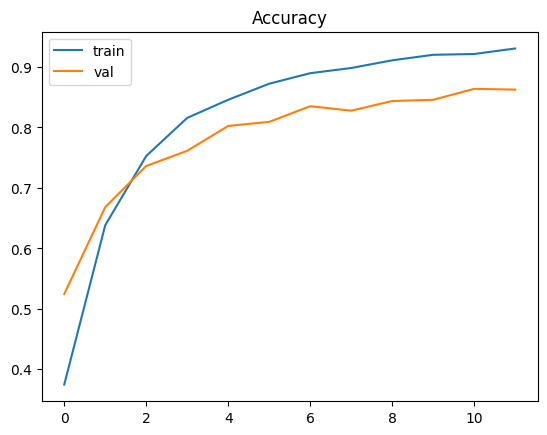

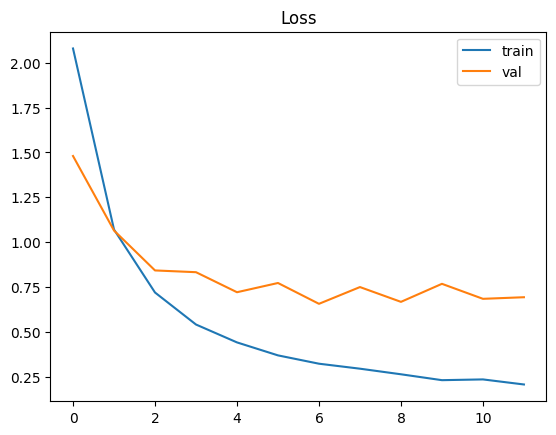

In [ ]:
#Plot accuracy/loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(["train","val"])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(["train","val"])
plt.show()

In [ ]:
#Predict mini holdout
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    classes=['mini_holdout'],
    target_size=image_size,
    class_mode='sparse',
    shuffle=False)

probabilities = model.predict(test_generator)
predictions = [np.argmax(p) for p in probabilities]

df_answers = pd.read_csv('/content/mini_holdout_answers.csv')
df_results = pd.DataFrame({"prediction": predictions, "actual": df_answers['ClassId']})
df_results.head()


Found 201 images belonging to 1 classes.
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step


,prediction,actual
0,16,16
1,1,1
2,38,38
3,34,33
4,11,11


Critical Signs Evaluation:
                 precision    recall  f1-score   support

           STOP       1.00      1.00      1.00        10
          Yield       1.00      1.00      1.00         4
       No Entry       1.00      1.00      1.00         2
Entry Forbidden       1.00      1.00      1.00         7

       accuracy                           1.00        23
      macro avg       1.00      1.00      1.00        23
   weighted avg       1.00      1.00      1.00        23



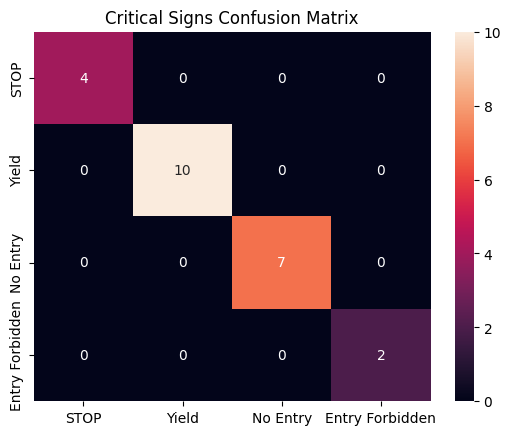

In [ ]:
#Define critical sign class IDs
critical_signs = {
    "STOP": 14,
    "Yield": 13,
    "No Entry": 17,
    "Entry Forbidden":15
}

#Filter predictions and ground truth for critical signs only
df_critical = df_results[df_results['actual'].isin(critical_signs.values())]

y_true = df_critical['actual']
y_pred = df_critical['prediction']

print("Critical Signs Evaluation:")
print(classification_report(y_true, y_pred, target_names=[k for k, v in critical_signs.items()]))

#Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=list(critical_signs.values()))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=critical_signs.keys(),
            yticklabels=critical_signs.keys())
plt.title('Critical Signs Confusion Matrix')
plt.show()

Per-class accuracy on mini holdout:
                             Sign  Accuracy
28                       Ice_Snow  0.250000
5                Speed_Limit_Ends  0.666667
24            Traffic_Light_Ahead  0.666667
31       Turning_Right_Compulsory  0.714286
33                     Ahead_Only  0.750000
0                        Speed_30  0.818182
7                       Speed_120  0.833333
23                 Roadwork_Ahead  0.857143
17              General Danger(!)  0.875000
3                        Speed_70  0.888889
2                        Speed_60  0.900000
10                       Priority  1.000000
8           Overtaking_Prohibited  1.000000
1                        Speed_50  1.000000
4                        Speed_80  1.000000
9   Overtakeing_Prohibited_Trucks  1.000000
15               Trucks_Forbidden  1.000000
14                Entry_Forbidden  1.000000
13                           STOP  1.000000
12                          Yield  1.000000
11            Priority_Road_Ahead  1.000

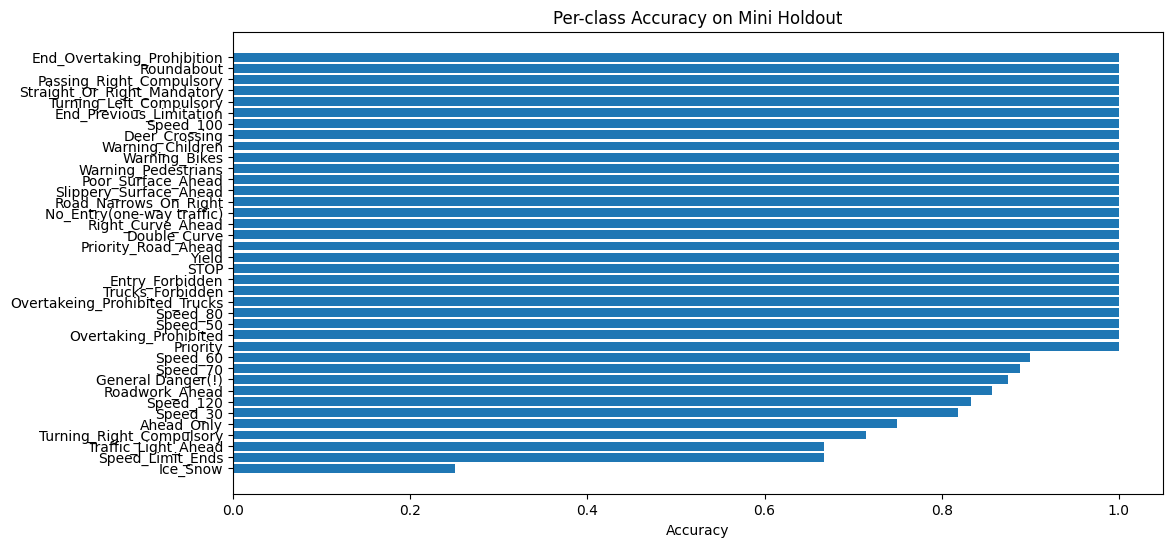

In [ ]:
# Compute accuracy per class for all 43 signs
per_class_accuracy = {}

for class_id in range(43):
    # Filter rows for this class
    df_class = df_results[df_results['actual'] == class_id]
    if len(df_class) > 0:  # avoid empty classes
        acc = accuracy_score(df_class['actual'], df_class['prediction'])
        per_class_accuracy[target_names[class_id]] = acc

# Convert to DataFrame for easier viewing
df_class_acc = pd.DataFrame(list(per_class_accuracy.items()), columns=['Sign', 'Accuracy'])
df_class_acc = df_class_acc.sort_values(by='Accuracy', ascending=True)

print("Per-class accuracy on mini holdout:")
print(df_class_acc)

# Optional: plot as bar chart
plt.figure(figsize=(12,6))
plt.barh(df_class_acc['Sign'], df_class_acc['Accuracy'])
plt.xlabel("Accuracy")
plt.title("Per-class Accuracy on Mini Holdout")
plt.show()

In [ ]:
#Predict whole holdout set and save
holdout_dir = '/content/'

holdout_datagen = ImageDataGenerator(rescale=1./255)
holdout_generator = holdout_datagen.flow_from_directory(
    holdout_dir,
    classes=['holdout'],
    target_size=image_size,
    class_mode=None,
    shuffle=False,
    batch_size=32
)

# Reset generator before prediction
holdout_generator.reset()
pred_probs = model.predict(holdout_generator, verbose=1)
pred_labels = np.argmax(pred_probs, axis=1)

# The filenames are in the same order as the generator
filenames = [f.split('/')[-1] for f in holdout_generator.filenames]

submission = pd.DataFrame({
    'Filename': filenames,
    'ClassId' : pred_labels
})

submission.to_csv('holdout_predictions.csv', index=False)
print("Submission saved as holdout_predictions.csv")

Found 12630 images belonging to 1 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


395/395 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
Submission saved as holdout_predictions.csv


## Testing the model
Once you have built and trained your model, the next step is to run the mini holdout images through it and see how well your model does at making predictions for images it has never seen before.

Since loading these images and formatting them for the model can be tricky, you may find the following code useful. This code only uses your model to predict the class label for a given image. You'll still need to compare those predictions to the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Previously, you were given a file that would check your results. This time you're given the answers to the first mini holdout dataset. You'll need to compare those predictions against the "ground truth" class labels in `mini_holdout_answers.csv` to evaluate how well the model does.

Make sure to use the insights gained from the mini hold out dataset in your executive summary.


```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['mini_holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```



##Mini Hold out Dataset


Once you feel confident, you will need to predict for the full holdout dataset using the following code, and submit your csv file:

```
from tensorflow.keras.preprocessing import image_dataset_from_directory
test_dir = '/content/'

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        classes=['holdout'],
        target_size=image_size,
        class_mode='sparse',
        shuffle=False)
probabilities = model.predict(test_generator)
predictions = [np.argmax(probas) for probas in probabilities]
```